# NOTEBOOK FOR THE ANALYSIS OF SINGLE-NUCLEI RNA-SEQUENCING DATA FROM MB243

In [13]:
import numpy as np
import pandas as pd
import scanpy as sc
import bbknn
import scrublet as scr
from matplotlib import rcParams

In [14]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [15]:
results_file = '/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/scRNA_analysis/scanpy/LFSMBP-Nuclei_scanpy.h5ad'  # the file that will store the analysis results


## READ IN THE DATA FOR MB243-NUCLEI AND PERFORM DOUBLET REMOVAL WITH SCRUBLET

In [16]:
adata = sc.read_10x_mtx(
    '/icgc/dkfzlsdf/analysis/B260/projects/chromothripsis_medulloblastoma/data/10XRNA5P/LFSMBP/LFSMBP-Nuclei/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata.var_names_make_unique()
adata

# make some metadata
adata.obs['sample'] = "LFSMBP"
adata.obs['technology'] = "Nuclei"
adata.obs['patient'] = "LFSMB"

... reading from cache file cache/icgc-dkfzlsdf-analysis-B260-projects-chromothripsis_medulloblastoma-data-10XRNA5P-STP-STP-Nuclei-outs-filtered_feature_bc_matrix-matrix.h5ad


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [17]:
adata.obs

,sample,technology,patient
AAACCTGCACATCCAA-1,STP,Nuclei,ST
AAACCTGCACTAGTAC-1,STP,Nuclei,ST
AAACCTGCATCATCCC-1,STP,Nuclei,ST
AAACCTGGTAGCGATG-1,STP,Nuclei,ST
AAACCTGGTAGCTCCG-1,STP,Nuclei,ST
...,...,...,...
TTTGTCAGTGCGCTTG-1,STP,Nuclei,ST
TTTGTCAGTGTTTGTG-1,STP,Nuclei,ST
TTTGTCAGTTAAAGAC-1,STP,Nuclei,ST
TTTGTCATCATCGGAT-1,STP,Nuclei,ST


In [18]:
scrub = scr.Scrublet(
        counts_matrix=adata.X,
        expected_doublet_rate=0.06,  # Default is 0.1
        random_state=0)

In [19]:
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.62
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.4%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 4.0%
Elapsed time: 7.0 seconds


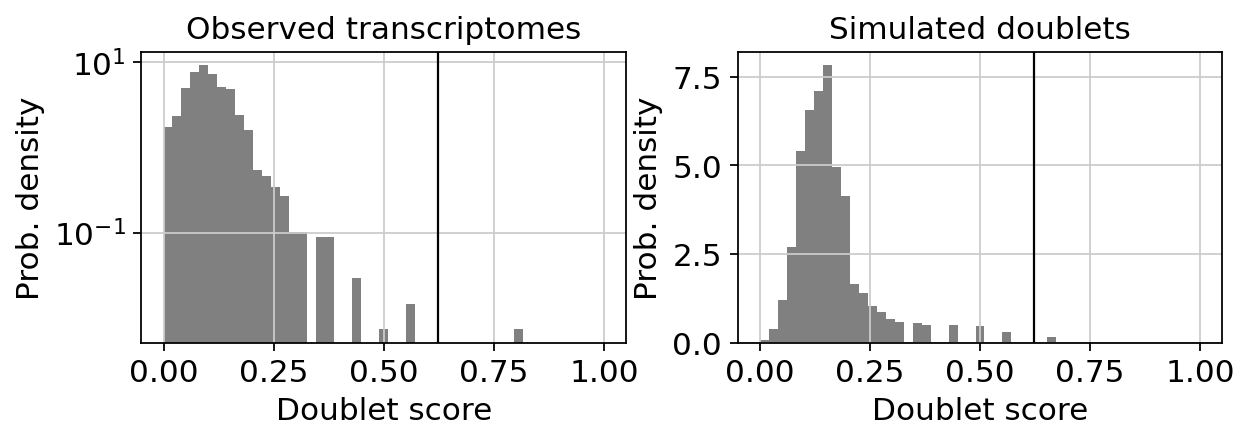

In [20]:
scrub.plot_histogram();

In [21]:
adata.obs['scrublet__predicted_multiplet'] = scrub.predicted_doublets_
adata.obs['scrublet__multiplet_scores'] = scrub.doublet_scores_obs_
adata.obs['scrublet__multiplet_zscores'] = scrub.z_scores_

In [22]:
adata.obs

,sample,technology,patient,scrublet__predicted_multiplet,scrublet__multiplet_scores,scrublet__multiplet_zscores
AAACCTGCACATCCAA-1,STP,Nuclei,ST,False,0.136483,-9.669419
AAACCTGCACTAGTAC-1,STP,Nuclei,ST,False,0.081705,-17.687129
AAACCTGCATCATCCC-1,STP,Nuclei,ST,False,0.048703,-31.075762
AAACCTGGTAGCGATG-1,STP,Nuclei,ST,False,0.159463,-7.937216
AAACCTGGTAGCTCCG-1,STP,Nuclei,ST,False,0.095554,-14.799332
...,...,...,...,...,...,...
TTTGTCAGTGCGCTTG-1,STP,Nuclei,ST,False,0.123987,-10.878876
TTTGTCAGTGTTTGTG-1,STP,Nuclei,ST,False,0.159463,-7.937216
TTTGTCAGTTAAAGAC-1,STP,Nuclei,ST,False,0.095554,-14.799332
TTTGTCATCATCGGAT-1,STP,Nuclei,ST,False,0.081705,-17.687129


In [23]:
# remove predicted doublets
adata = adata[adata.obs['scrublet__predicted_multiplet'] == False]

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


normalizing counts per cell
    finished (0:00:00)


/home/przybilm/.local/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


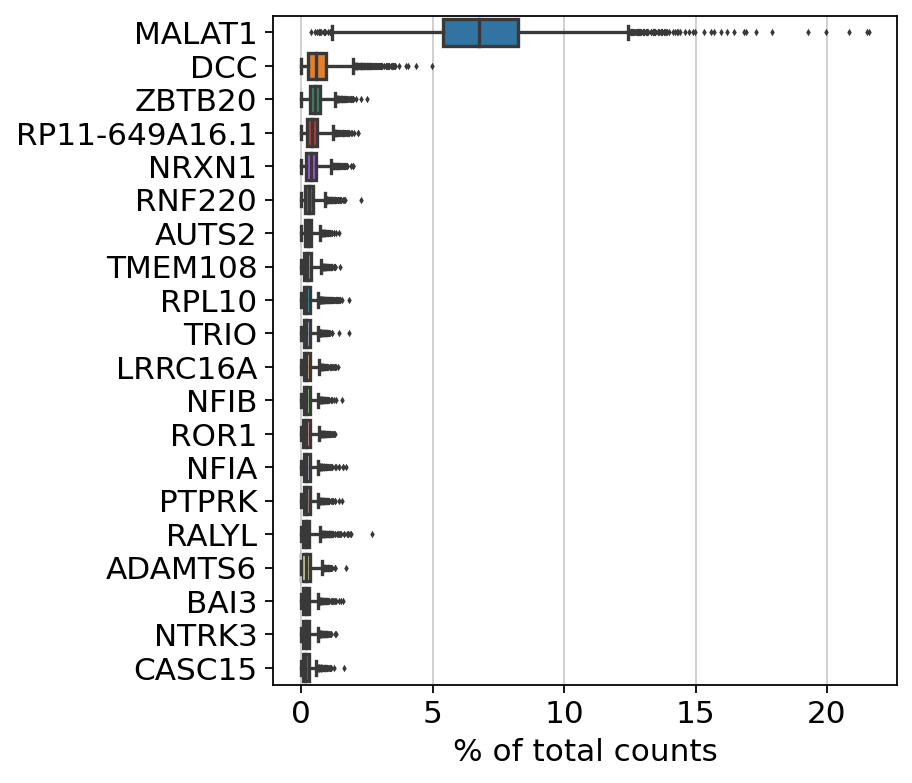

In [24]:
# preprocessing
sc.pl.highest_expr_genes(adata, n_top=20,)

## START PERFORMING THE INITIAL QUALITY CONTROL

In [25]:
# basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 11919 genes that are detected in less than 3 cells


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [26]:
# calculate some quality metrics as for instance mitochondrial percentage
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# and for ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(('RPS','RPL'))  # annotate the group of ribosomal genes as 'ribo'
sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'sample' as categorical
... storing 'technology' as categorical
... storing 'patient' as categorical
... storing 'feature_types' as categorical


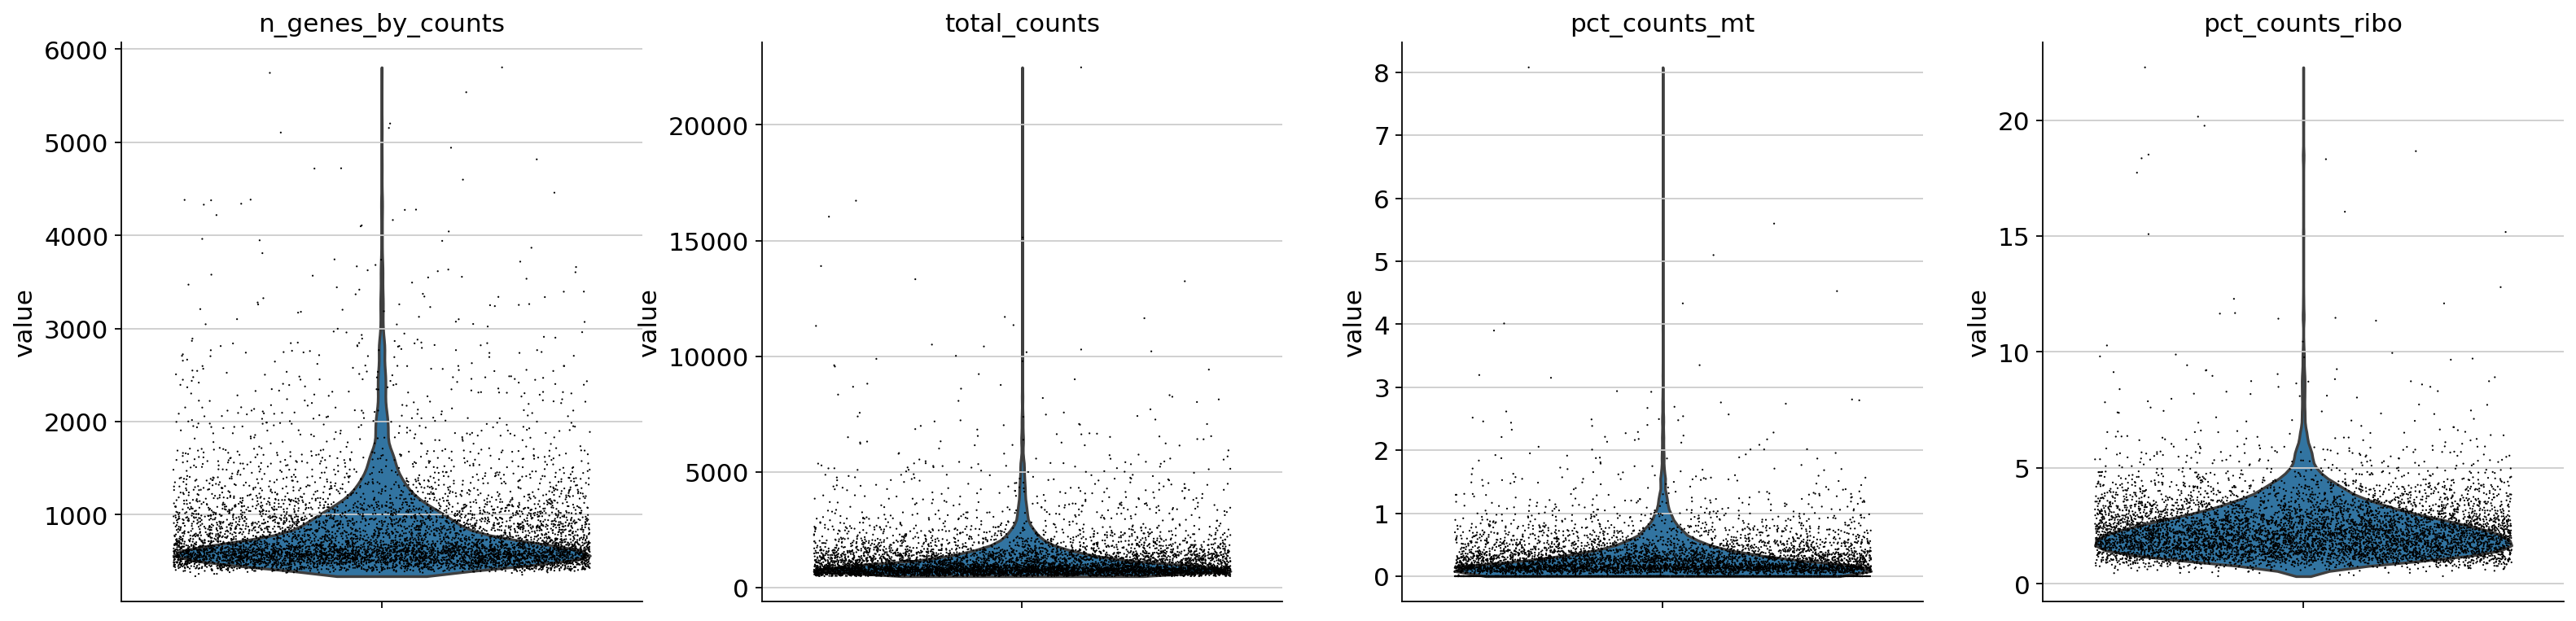

In [27]:
# visualize some QC metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],
             jitter=0.4, multi_panel=True)

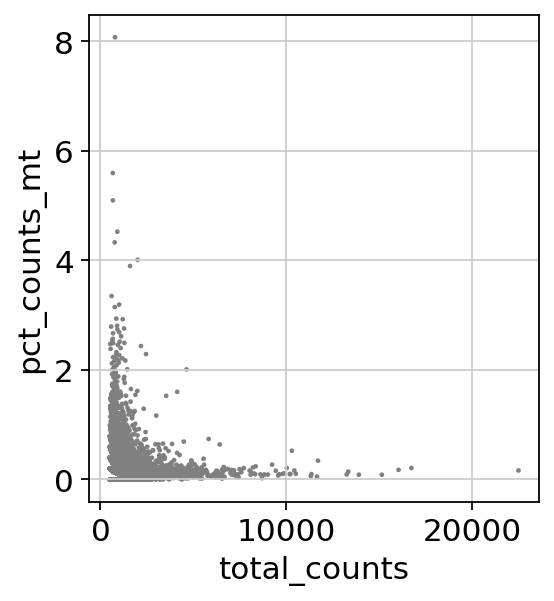

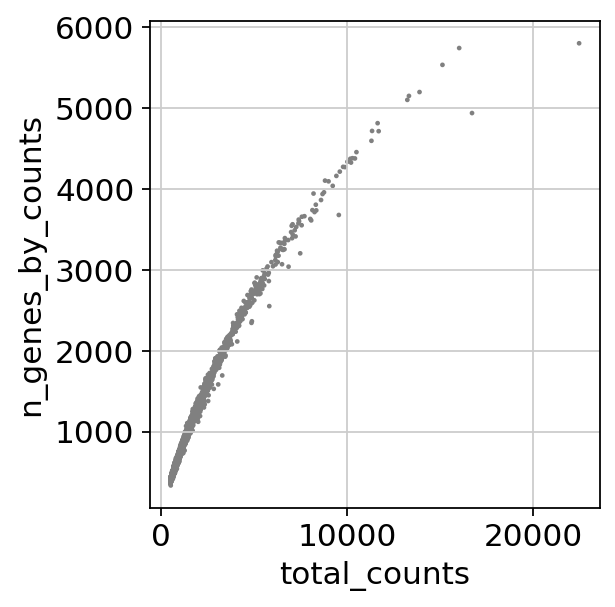

In [28]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [29]:
# do the actual filtering by slicing the object
adata = adata[300 < adata.obs.n_genes_by_counts, :]
adata = adata[adata.obs.n_genes_by_counts < 6000, :]
adata = adata[500 < adata.obs.total_counts, :]
adata = adata[adata.obs.total_counts < 25000, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
adata = adata[adata.obs.pct_counts_ribo < 10, :]

/home/przybilm/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [30]:
adata

View of AnnData object with n_obs × n_vars = 6635 × 20819
    obs: 'sample', 'technology', 'patient', 'scrublet__predicted_multiplet', 'scrublet__multiplet_scores', 'scrublet__multiplet_zscores', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo'

In [31]:
# calculate mean number of genes detected
mean_genes = adata.obs['n_genes'].mean()
print(mean_genes)

# calculate mean number of transcripts detected
mean_counts = adata.obs['total_counts'].mean()
print(mean_counts)

846.4262245666918
1244.98583984375


## PERFORM NORMALIZATION, PCA AND CLUSTERING

In [32]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/home/przybilm/.local/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [33]:
sc.pp.log1p(adata)

In [34]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


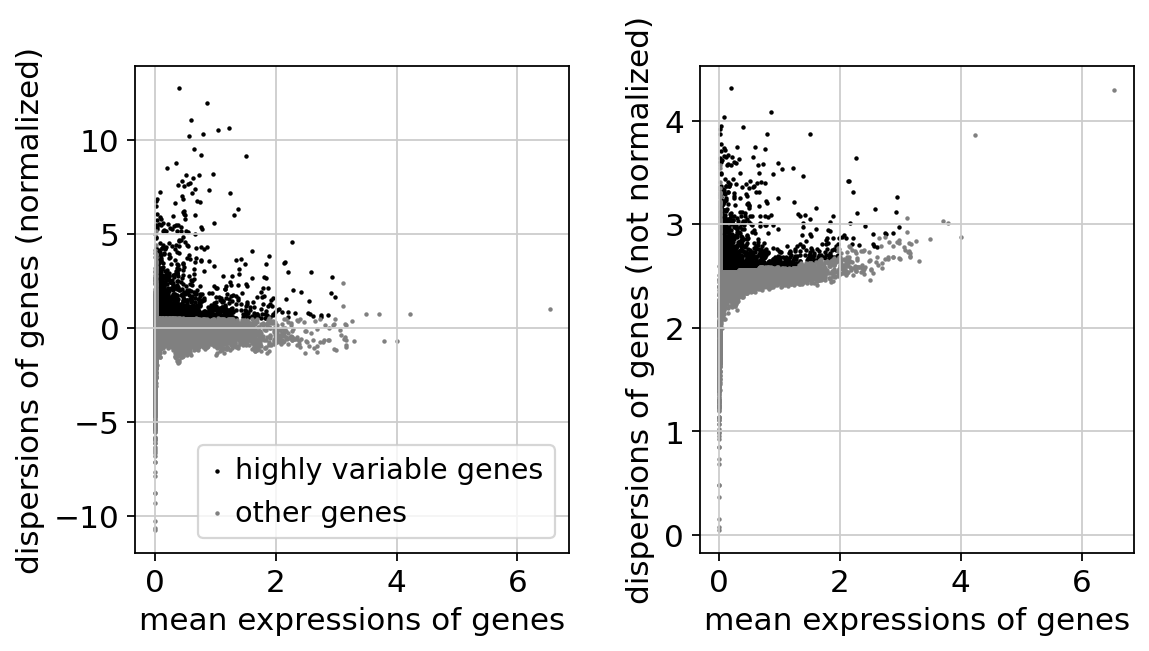

In [35]:
sc.pl.highly_variable_genes(adata)

In [36]:
# set the raw attribute of anndata
adata.raw = adata

In [37]:
adata = adata[:, adata.var.highly_variable]

In [38]:
# regress out effects of total counts per cell and the percentage of mitochondrial genes
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

regressing out ['total_counts', 'pct_counts_mt', 'pct_counts_ribo']
    sparse input is densified and may lead to high memory use
    finished (0:00:20)


In [39]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:07)


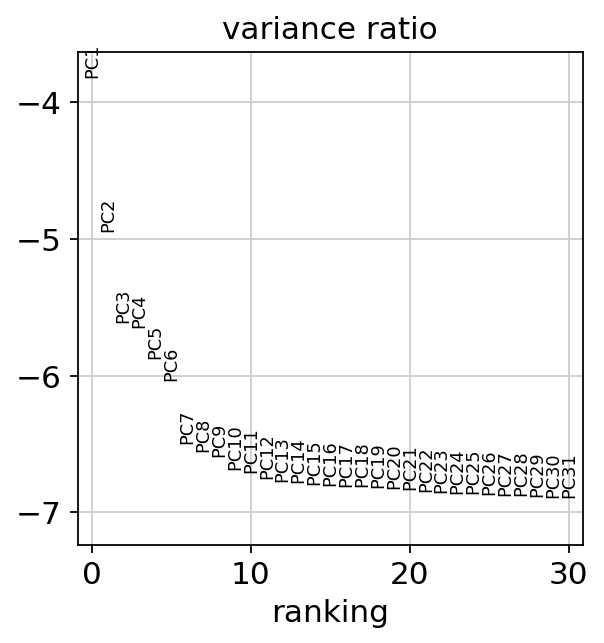

In [40]:
sc.pl.pca_variance_ratio(adata, log=True)

In [41]:
adata

AnnData object with n_obs × n_vars = 6635 × 3349
    obs: 'sample', 'technology', 'patient', 'scrublet__predicted_multiplet', 'scrublet__multiplet_scores', 'scrublet__multiplet_zscores', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [42]:
# compute nearest neighbors, UMAP and clustering
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=7)
sc.tl.umap(adata, n_components=2, min_dist=0.1,  # Scanpy default = 0.05
           spread=1.0, copy=False, random_state=0)
sc.tl.louvain(adata, resolution= 0.4)
sc.tl.leiden(adata, resolution= 0.4)

computing neighbors
    using 'X_pca' with n_pcs = 7
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


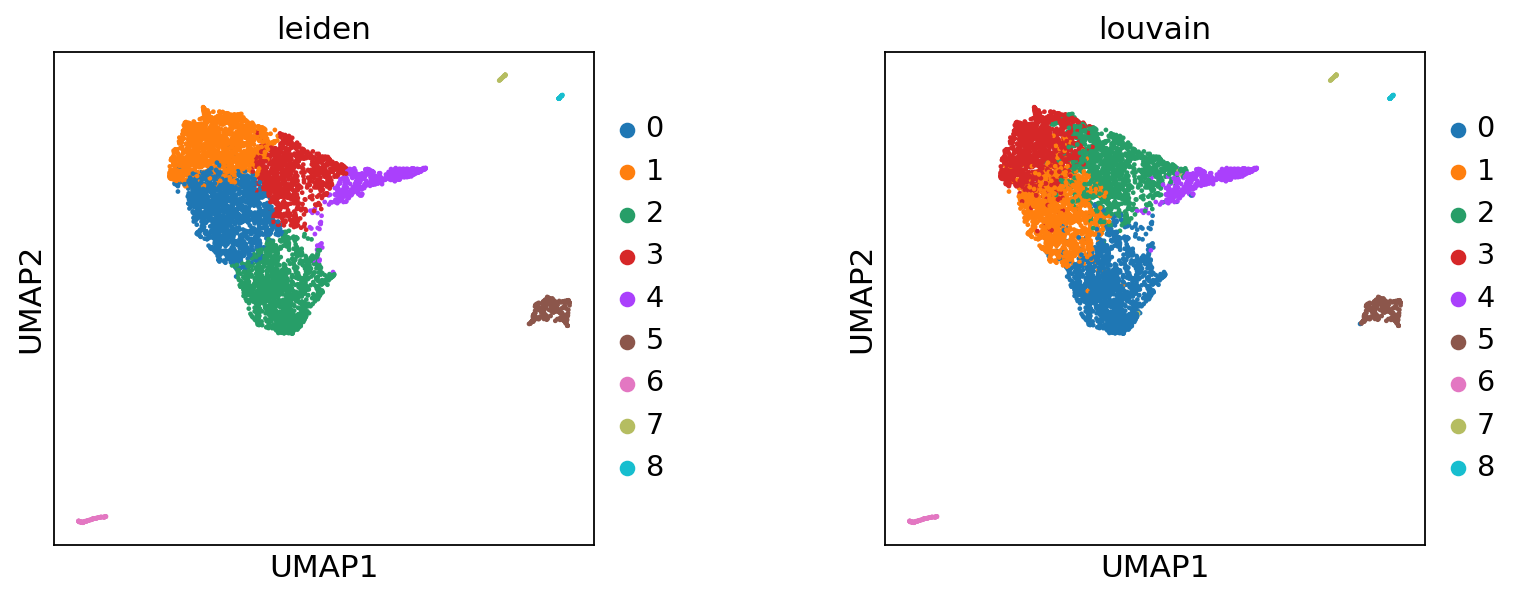

In [43]:
sc.pl.umap(adata, color=['leiden', 'louvain'], save = '_STP-Nuclei.pdf', wspace = 0.4)

ranking genes


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:13)


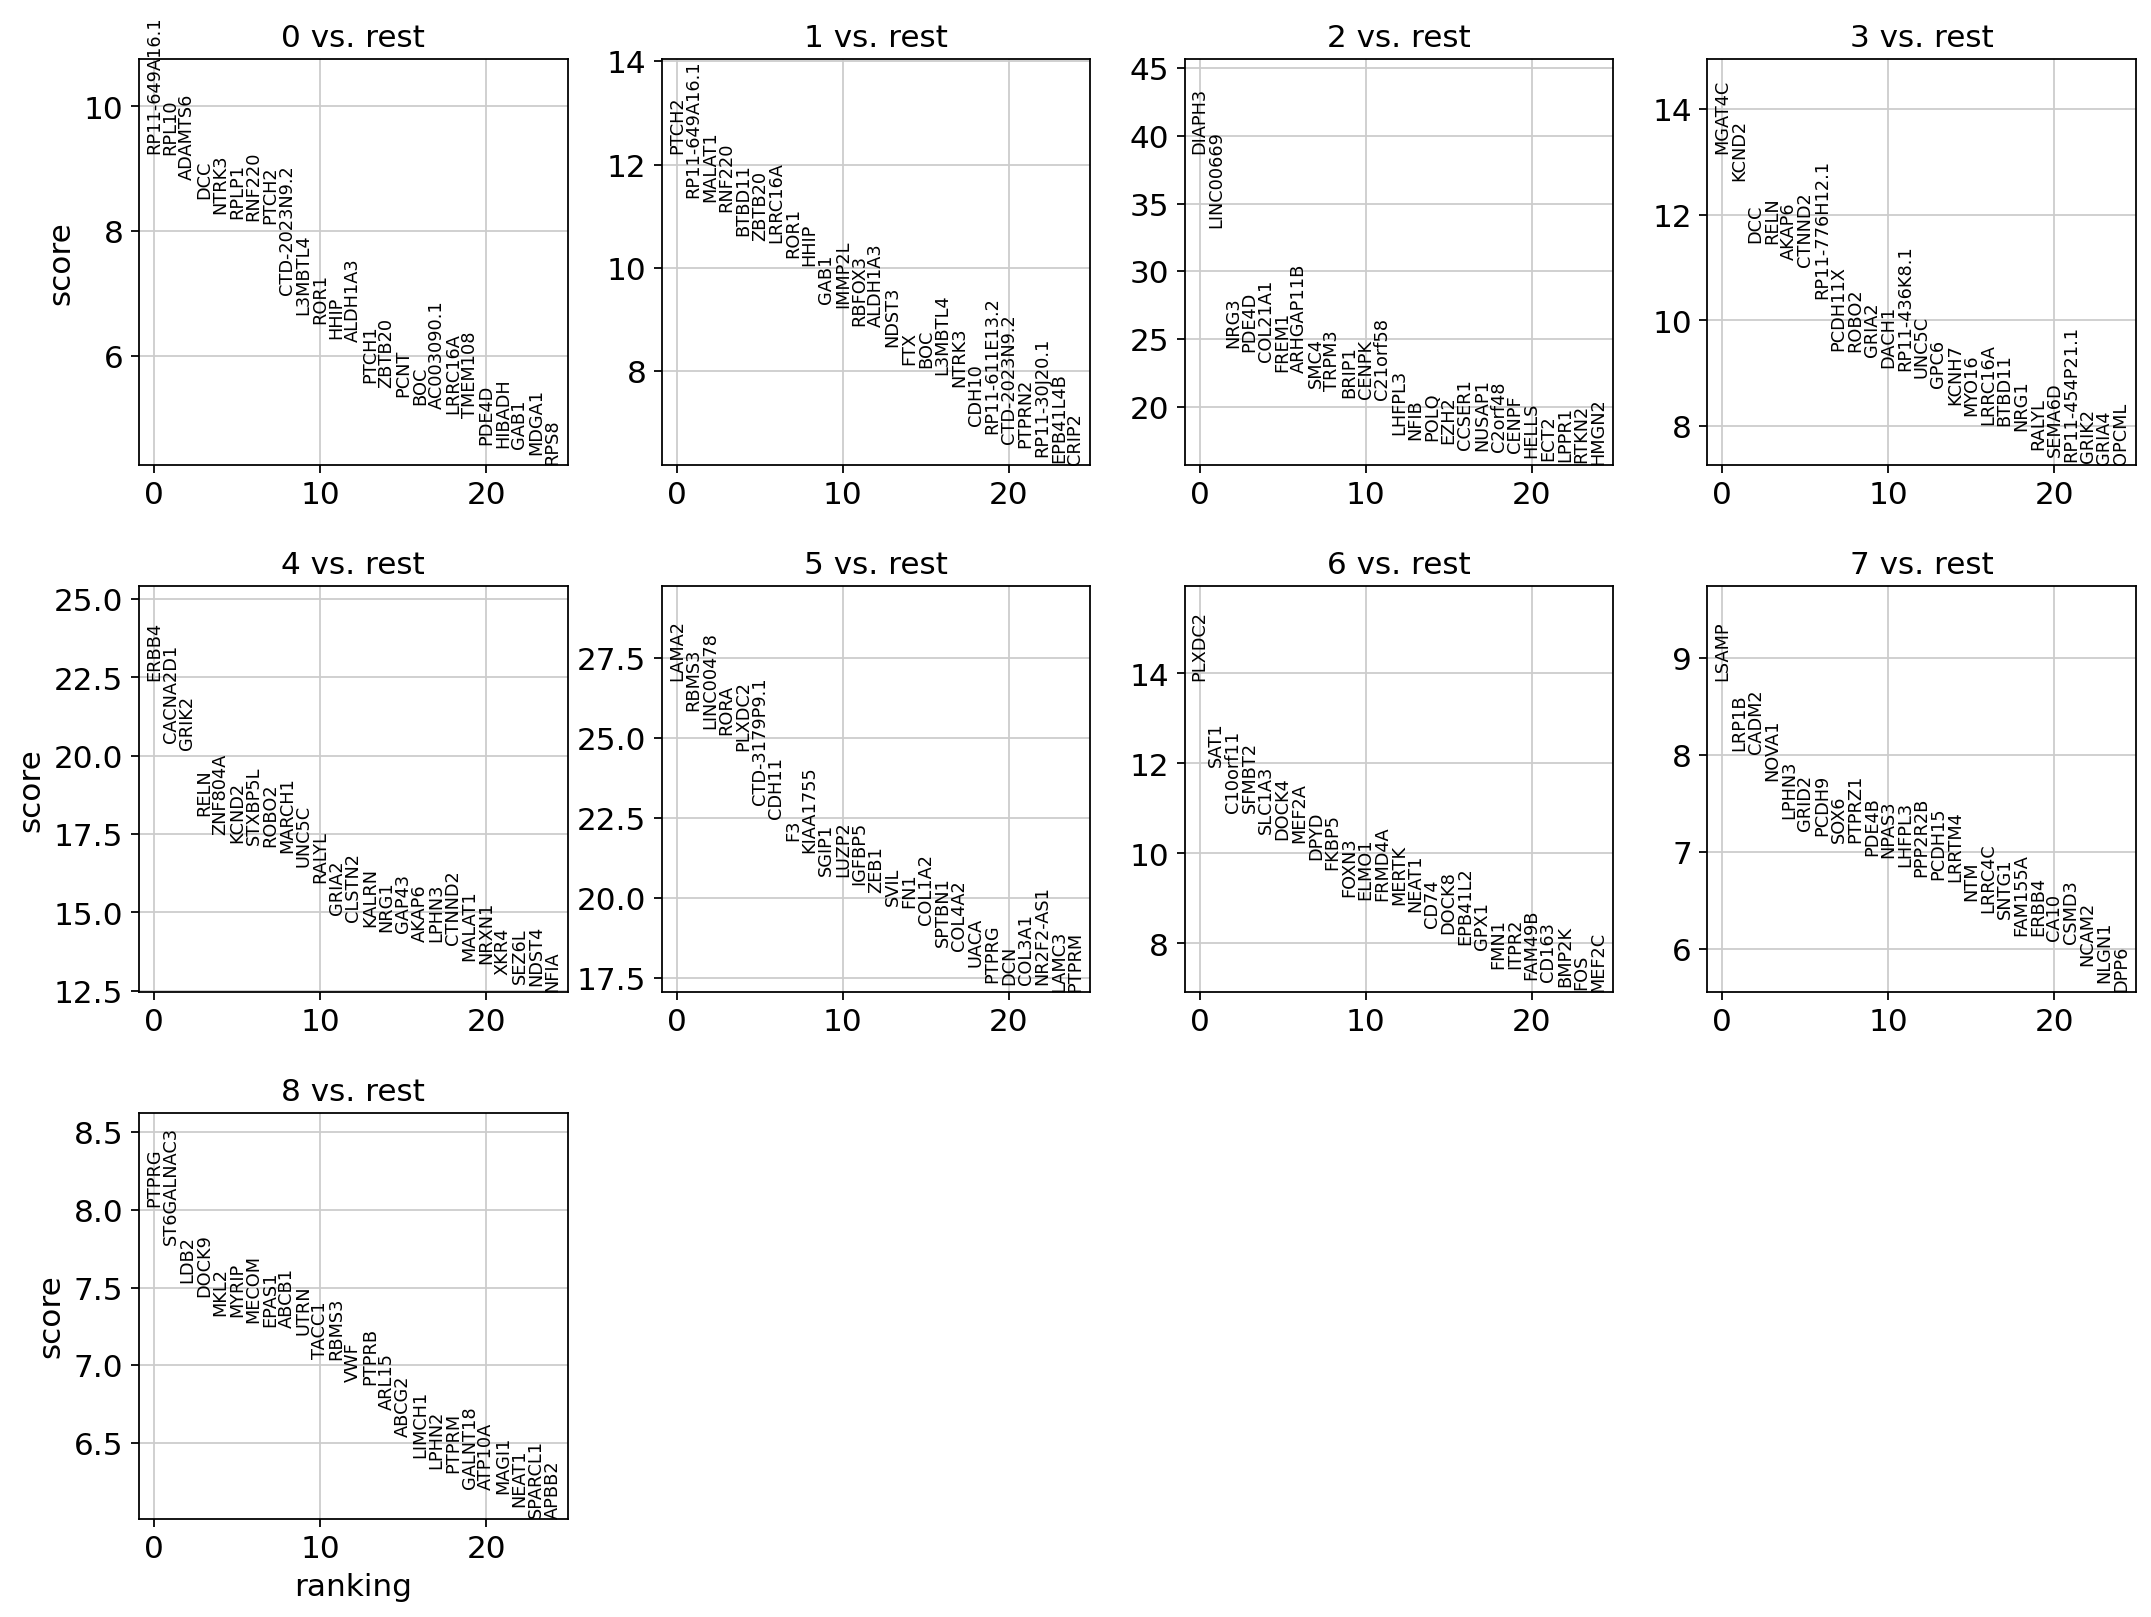

In [44]:
# find marker genes for each cluster using the Wilcoxon rank sum test
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, save = "_STP-Nuclei_leiden.pdf")

In [45]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7,8
0,RP11-649A16.1,PTCH2,DIAPH3,MGAT4C,ERBB4,LAMA2,PLXDC2,LSAMP,PTPRG
1,RPL10,RP11-649A16.1,LINC00669,KCND2,CACNA2D1,RBMS3,SAT1,LRP1B,ST6GALNAC3
2,ADAMTS6,MALAT1,NRG3,DCC,GRIK2,LINC00478,C10orf11,CADM2,LDB2
3,DCC,RNF220,PDE4D,RELN,RELN,RORA,SFMBT2,NOVA1,DOCK9
4,NTRK3,BTBD11,COL21A1,AKAP6,ZNF804A,PLXDC2,SLC1A3,LPHN3,MKL2


In [46]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
wilcoxon_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', "scores", 'logfoldchanges', "pvals", 'pvals_adj']})

In [47]:
wilcoxon_df.to_csv("/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/STP-Nuclei_DEG_wilcoxon.csv")

In [48]:
new_cluster_names = ['cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6', 'cluster7', 'cluster8']
adata.rename_categories('leiden', new_cluster_names)

old_to_new = dict(
    cluster0='malignant SHH I',
    cluster1='malignant SHH II',
    cluster2='malignant cycling',
    cluster3='neuronal development I',
    cluster4='neuronal development II',
    cluster5='meninge cells',
    cluster6='macrophages',
    cluster7='purkinje cells',
    cluster8='endothelial cells'
)

adata.obs['new_clusters'] = (
    adata.obs['leiden']
    .map(old_to_new)
    .astype('category')
)

/home/przybilm/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


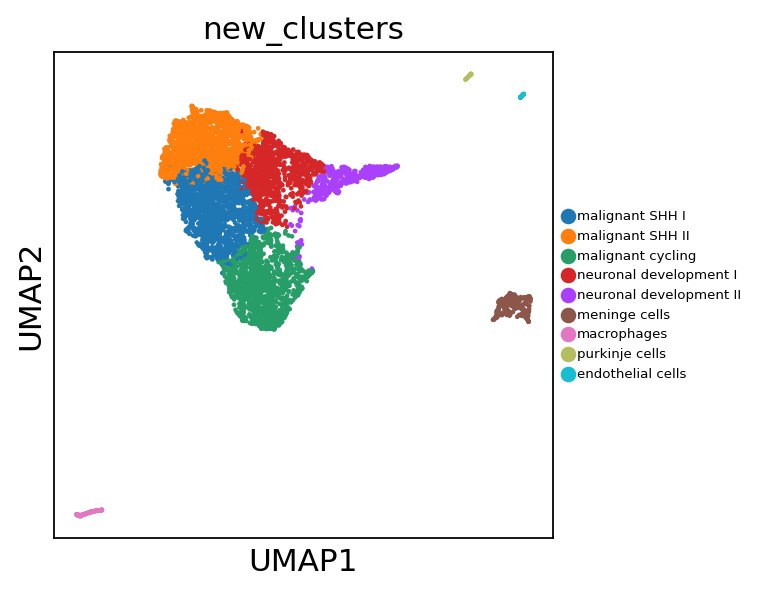

In [50]:
sc.pl.umap(adata, color=['new_clusters'], save = '_STP-Nuclei_Aurelie_CellType.pdf', wspace = 0.6, legend_fontsize = 6)

In [51]:
adata.write("/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/STP-Nuclei_Aurelie_Celltype_scanpy.h5ad")

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


In [52]:
metadata = pd.DataFrame(adata.obs, index=adata.obs_names)
metadata.to_csv('/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/STP-Nuclei_metadata.csv')

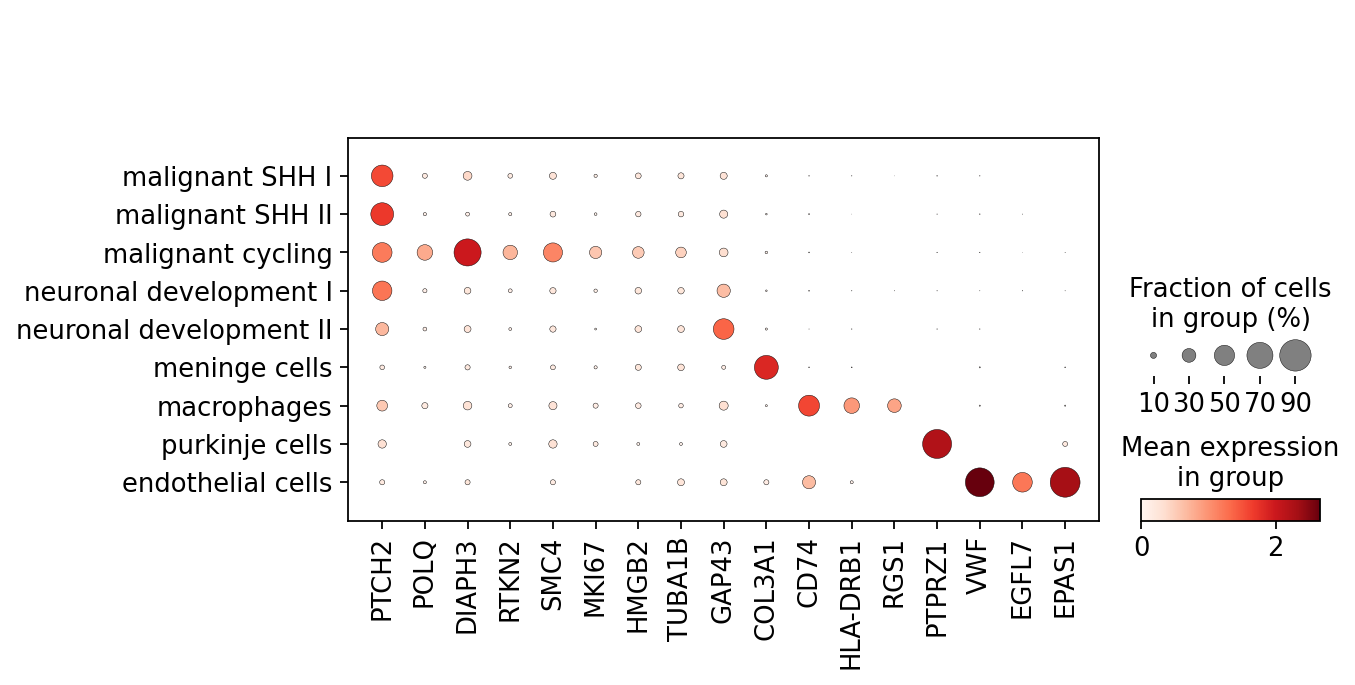

In [53]:
aurelie_marker_genes = ["PTCH2", "POLQ", "DIAPH3", "RTKN2", "SMC4", "MKI67", "HMGB2", "TUBA1B",
                "GAP43", "COL3A1", "CD74", "HLA-DRB1", "RGS1", "PTPRZ1", "VWF", "EGFL7", "EPAS1",]

sc.pl.dotplot(adata, aurelie_marker_genes, groupby='new_clusters')

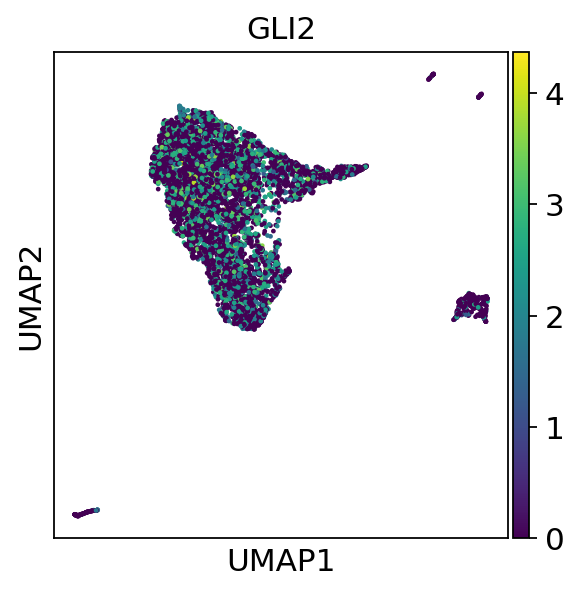

In [54]:
sc.pl.umap(adata, color=['GLI2'], sort_order = False, wspace = 0.5, save = '_STP-Nuclei_GLI2_marker_visualization.pdf')

In [9]:
adata.obs

,sample,technology,patient,scrublet__predicted_multiplet,scrublet__multiplet_scores,scrublet__multiplet_zscores,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,louvain,leiden,new_clusters
AAACCTGCACATCCAA-1,STP,Nuclei,ST,False,0.136483,-9.669419,521,520,660.0,0.0,0.000000,19.0,2.878788,1,cluster0,malignant SHH I
AAACCTGCACTAGTAC-1,STP,Nuclei,ST,False,0.081705,-17.687129,567,566,753.0,2.0,0.265604,9.0,1.195219,1,cluster0,malignant SHH I
AAACCTGCATCATCCC-1,STP,Nuclei,ST,False,0.048703,-31.075762,424,424,548.0,3.0,0.547445,36.0,6.569343,1,cluster2,malignant cycling
AAACCTGGTAGCGATG-1,STP,Nuclei,ST,False,0.159463,-7.937216,3130,3125,6145.0,7.0,0.113914,83.0,1.350692,2,cluster3,neuronal development I
AAACCTGGTAGCTCCG-1,STP,Nuclei,ST,False,0.095554,-14.799332,472,472,596.0,1.0,0.167785,12.0,2.013423,3,cluster1,malignant SHH II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTGCGCTTG-1,STP,Nuclei,ST,False,0.123987,-10.878876,1360,1359,1929.0,13.0,0.673924,33.0,1.710731,1,cluster0,malignant SHH I
TTTGTCAGTGTTTGTG-1,STP,Nuclei,ST,False,0.159463,-7.937216,963,962,1256.0,2.0,0.159236,29.0,2.308917,1,cluster1,malignant SHH II
TTTGTCAGTTAAAGAC-1,STP,Nuclei,ST,False,0.095554,-14.799332,646,646,833.0,7.0,0.840336,26.0,3.121248,1,cluster0,malignant SHH I
TTTGTCATCATCGGAT-1,STP,Nuclei,ST,False,0.081705,-17.687129,1216,1216,1729.0,9.0,0.520532,37.0,2.139965,0,cluster2,malignant cycling


## PROJECT ALIGNED SCDNA CLONES ONTO THE EMBEDDING

In [55]:
scDNA_clones = pd.read_csv("/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/infercnv_MB/scRNA_scDNA/STP-Nuclei/STP-Nuclei_scDNA_clones_filtered_cells.txt", sep = '\t', index_col=0)
scDNA_clones

,clone_id,pearson.correlation,Clone1,Clone2,Clone3,Clone4,Clone5,Clone6,Clone1_pval,Clone2_pval,Clone3_pval,Clone4_pval,Clone5_pval,Clone6_pval,num_pval_clones,min_pval,padj
Cell_barcode,,,,,,,,,,,,,,,,,
CTGCCTAGTAGAAGGA-1,Clone2,0.649254,-0.000841,0.649254,0.632943,0.644557,0.583359,0.615597,1.001,0.001,0.001,0.001,0.007,0.001,4,0.001,0.006
TGCGGGTTCTGCCAGG-1,Clone2,0.596083,0.001907,0.596083,0.509977,0.590394,0.537009,0.536447,1.001,0.001,0.116,0.001,0.001,0.001,4,0.001,0.006
TTGAACGTCAGGATCT-1,Clone4,0.641362,-0.000441,0.631324,0.627093,0.641362,0.564845,0.591201,1.001,0.001,0.001,0.001,0.056,0.001,4,0.001,0.006
ACACCCTTCTGACCTC-1,Clone2,0.581338,0.000191,0.581338,0.487517,0.567794,0.492191,0.544243,1.001,0.001,0.259,0.001,0.142,0.001,3,0.001,0.006
AGCGGTCTCTGAAAGA-1,Clone4,0.592047,0.000246,0.584386,0.552091,0.592047,0.501860,0.568746,1.001,0.001,0.001,0.001,0.554,0.001,4,0.001,0.006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GAACGGACATCACGAT-1,Clone3,0.614594,-0.000723,0.566619,0.614594,0.583934,0.587010,0.441758,1.001,0.001,0.001,0.001,0.001,1.001,4,0.001,0.006
TAAACCGTCACCGTAA-1,Clone5,0.549346,0.002283,0.548788,0.541605,0.541038,0.549346,0.410470,1.001,0.001,0.001,0.001,0.001,1.001,4,0.001,0.006
GATCGTATCACTTATC-1,Clone4,0.528596,0.004069,0.505903,0.454567,0.528596,0.411848,0.385346,1.001,0.001,0.001,0.001,0.355,0.990,3,0.001,0.006


In [56]:
scDNA_clones = scDNA_clones.loc[scDNA_clones['padj'] <= 0.05, :]
scDNA_clones

,clone_id,pearson.correlation,Clone1,Clone2,Clone3,Clone4,Clone5,Clone6,Clone1_pval,Clone2_pval,Clone3_pval,Clone4_pval,Clone5_pval,Clone6_pval,num_pval_clones,min_pval,padj
Cell_barcode,,,,,,,,,,,,,,,,,
CTGCCTAGTAGAAGGA-1,Clone2,0.649254,-0.000841,0.649254,0.632943,0.644557,0.583359,0.615597,1.001,0.001,0.001,0.001,0.007,0.001,4,0.001,0.006
TGCGGGTTCTGCCAGG-1,Clone2,0.596083,0.001907,0.596083,0.509977,0.590394,0.537009,0.536447,1.001,0.001,0.116,0.001,0.001,0.001,4,0.001,0.006
TTGAACGTCAGGATCT-1,Clone4,0.641362,-0.000441,0.631324,0.627093,0.641362,0.564845,0.591201,1.001,0.001,0.001,0.001,0.056,0.001,4,0.001,0.006
ACACCCTTCTGACCTC-1,Clone2,0.581338,0.000191,0.581338,0.487517,0.567794,0.492191,0.544243,1.001,0.001,0.259,0.001,0.142,0.001,3,0.001,0.006
AGCGGTCTCTGAAAGA-1,Clone4,0.592047,0.000246,0.584386,0.552091,0.592047,0.501860,0.568746,1.001,0.001,0.001,0.001,0.554,0.001,4,0.001,0.006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GAACGGACATCACGAT-1,Clone3,0.614594,-0.000723,0.566619,0.614594,0.583934,0.587010,0.441758,1.001,0.001,0.001,0.001,0.001,1.001,4,0.001,0.006
TAAACCGTCACCGTAA-1,Clone5,0.549346,0.002283,0.548788,0.541605,0.541038,0.549346,0.410470,1.001,0.001,0.001,0.001,0.001,1.001,4,0.001,0.006
GATCGTATCACTTATC-1,Clone4,0.528596,0.004069,0.505903,0.454567,0.528596,0.411848,0.385346,1.001,0.001,0.001,0.001,0.355,0.990,3,0.001,0.006


In [57]:
adata.obs['clone_id'] = scDNA_clones['clone_id']
adata.obs['padj'] = scDNA_clones['padj']

In [58]:
adata.uns['clone_id_colors'] = np.array(["#377EB8", "#E41A1C", "#984EA3", "#FF7F00", "#FFFF33", "#808080"])

In [12]:
t=adata.raw.X.toarray()
pd.DataFrame(data=t, index=adata.obs_names, columns=adata.raw.var_names).to_csv("/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/scRNA_analysis/scanpy/STP-Nuclei_raw_matrix.csv")

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'clone_id' as categorical


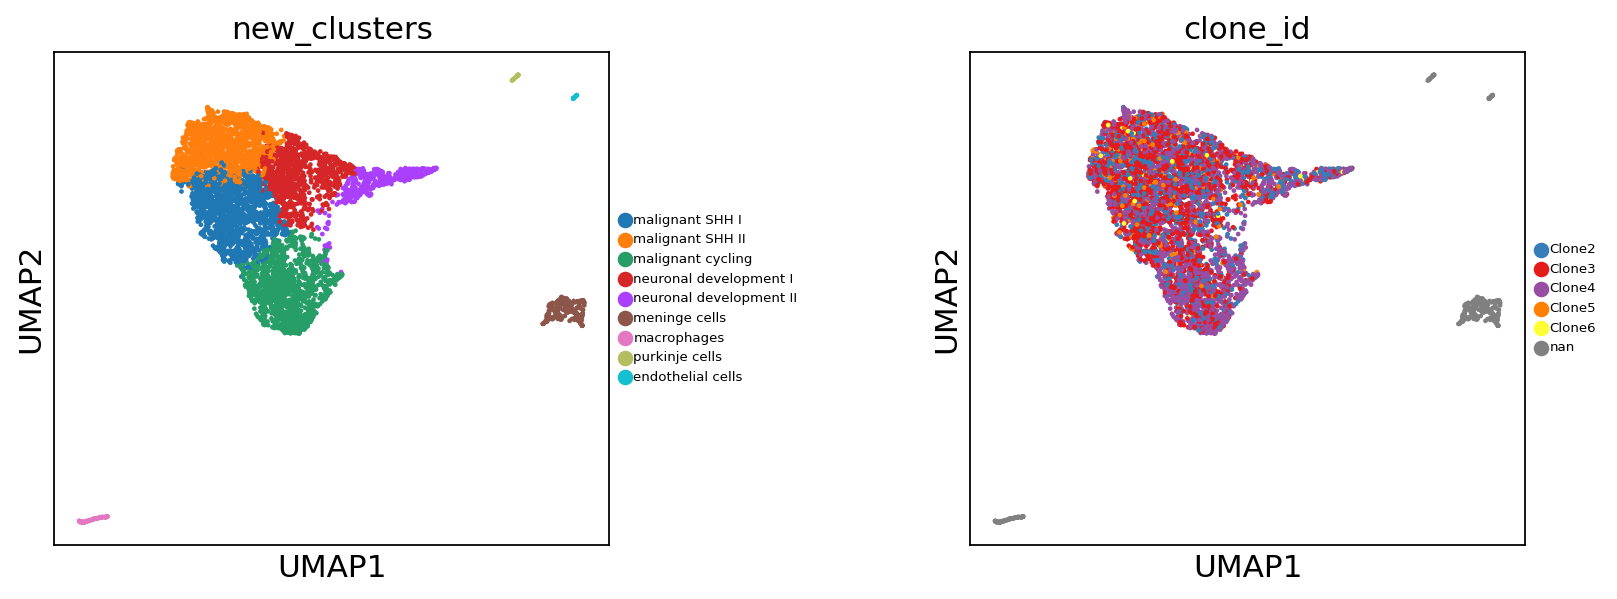

In [59]:
sc.pl.umap(adata, color=['new_clusters', 'clone_id'], save = '_STP-Nuclei_scDNA_clones_integrated2.pdf', wspace = 0.5, legend_fontsize = 6)

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


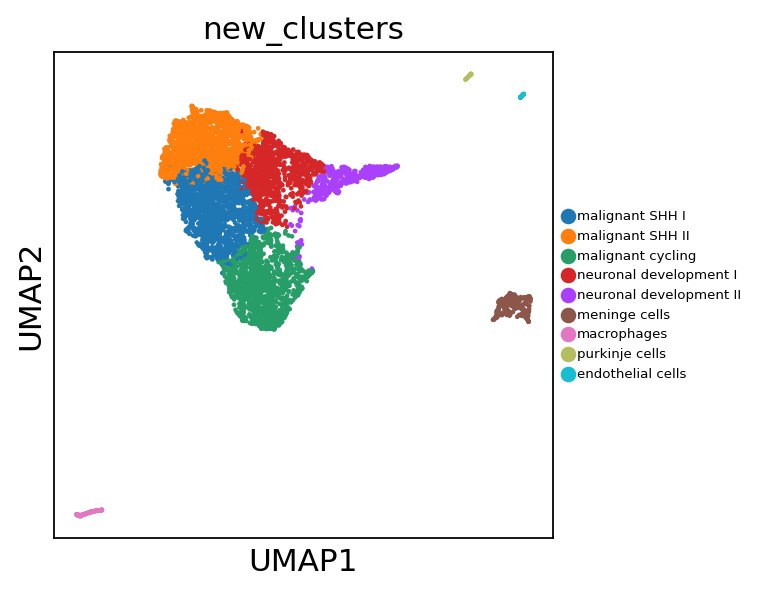

In [60]:
sc.pl.umap(adata, color=['new_clusters'], save = '_STP-Nuclei_cell_types.pdf', wspace = 0.5, legend_fontsize = 6)

In [61]:
# assign the column with the cell_type id in the metadata of the annData object
metadata = pd.DataFrame(adata.obs, index=adata.obs_names)
metadata.to_csv('/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/infercnv_MB/STP-Nuclei_metadata.csv')

ranking genes


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:10)


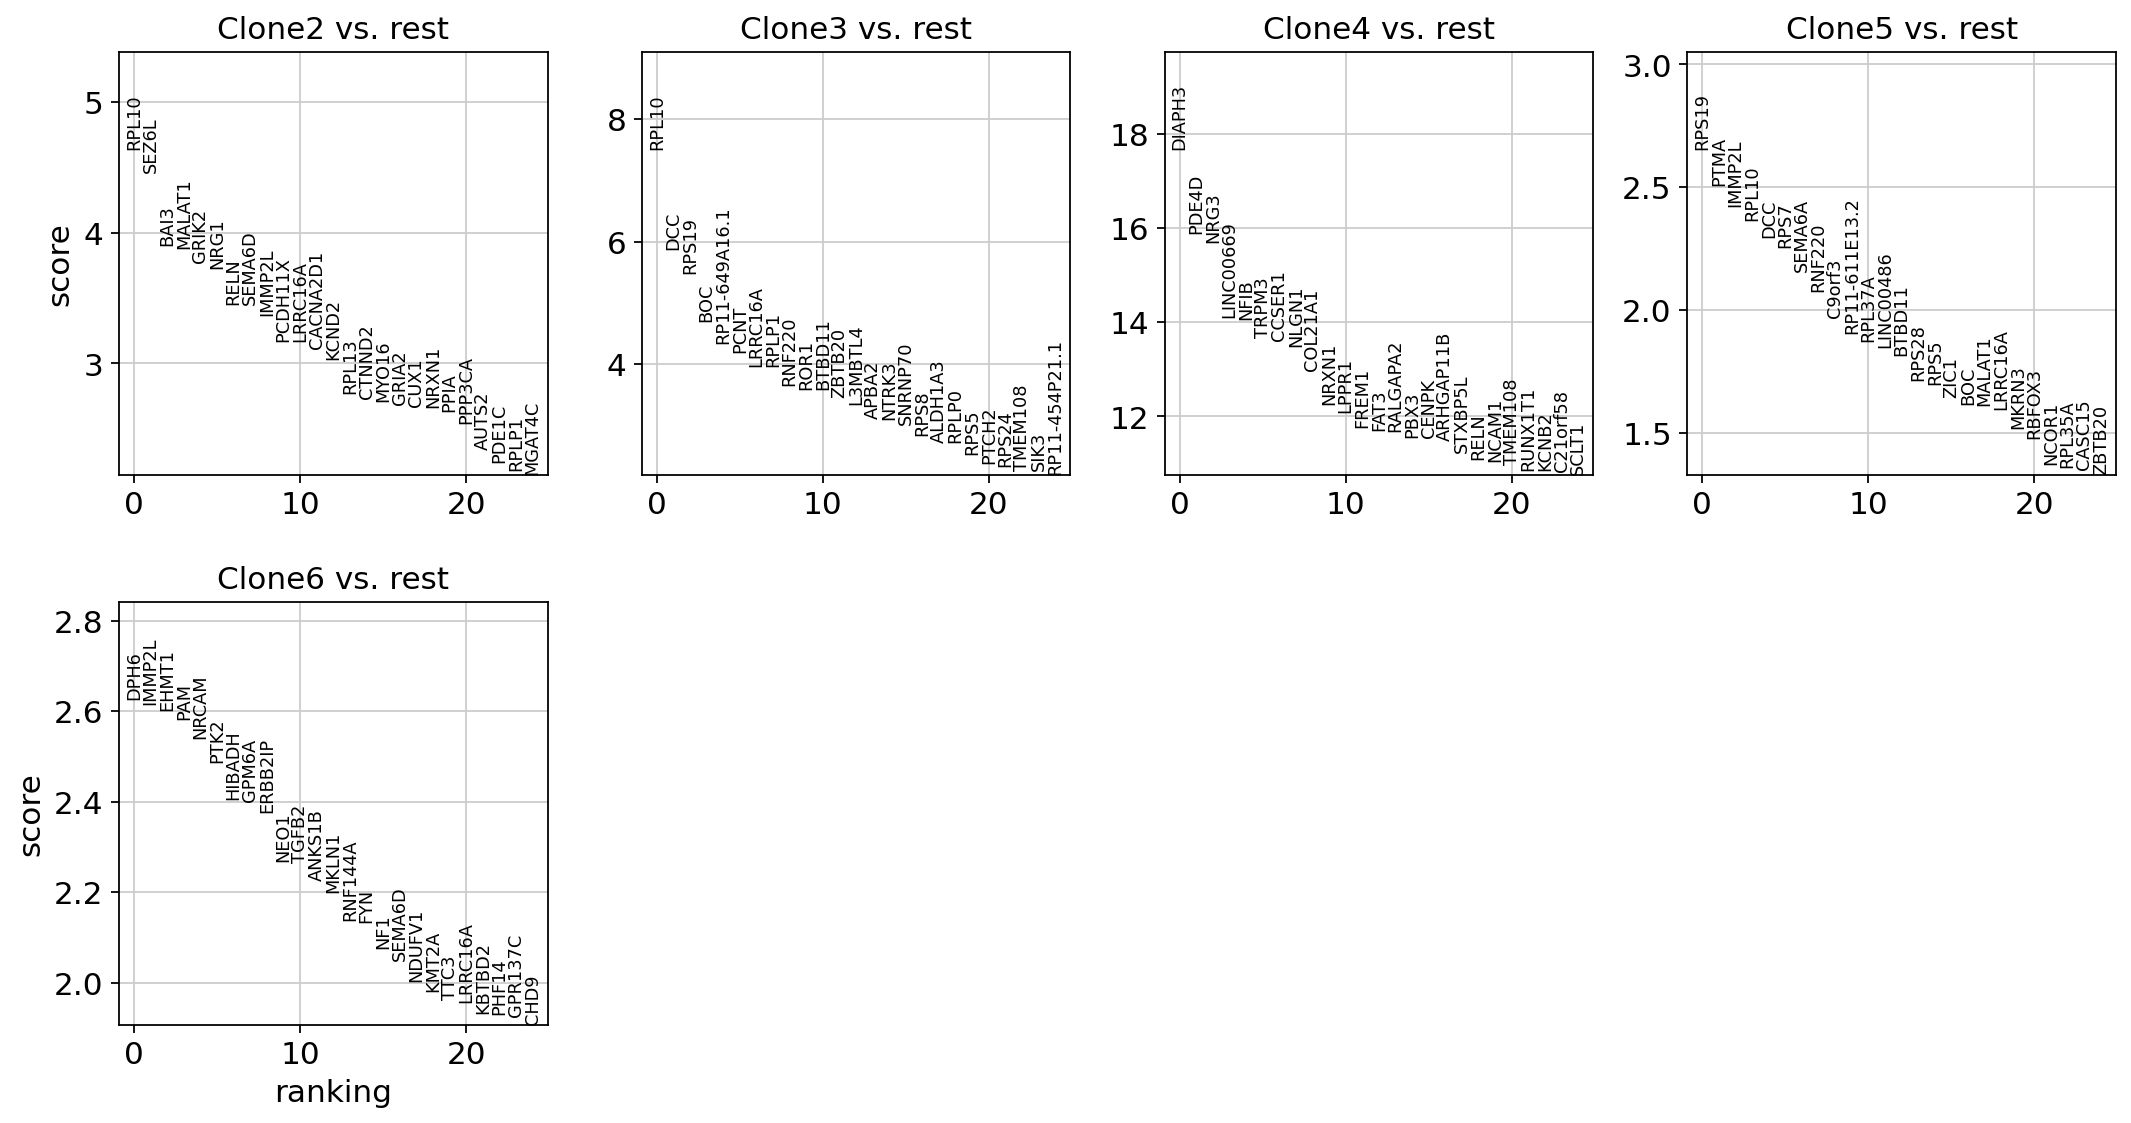

In [62]:
# find marker genes for each cluster using the Wilcoxon rank sum test
sc.tl.rank_genes_groups(
            adata,
            groupby='clone_id',
            groups=['Clone2', 'Clone3', 'Clone4', 'Clone5', 'Clone6'],
            reference='rest',
            use_raw=True,
            method='wilcoxon',
            n_genes=2000,
            corr_method='benjamini-hochberg'
        )
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [63]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
wilcoxon_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges', 'scores', "pvals", 'pvals_adj']})
wilcoxon_df

,Clone2_n,Clone2_l,Clone2_s,Clone2_p,Clone3_n,Clone3_l,Clone3_s,Clone3_p,Clone4_n,Clone4_l,Clone4_s,Clone4_p,Clone5_n,Clone5_l,Clone5_s,Clone5_p,Clone6_n,Clone6_l,Clone6_s,Clone6_p
0,RPL10,0.159277,4.640238,0.009056,RPL10,0.227999,7.507580,3.134831e-10,DIAPH3,1.914203,17.671806,1.439555e-65,RPS19,0.334719,2.654582,0.999801,DPH6,1.236608,2.626897,0.999905
1,SEZ6L,0.293934,4.462032,0.014085,DCC,0.369474,5.867707,4.380537e-06,PDE4D,1.077060,15.886427,8.190922e-53,PTMA,0.352484,2.506419,0.999801,IMMP2L,0.780103,2.615905,0.999905
2,BAI3,0.177278,3.903626,0.107198,RPS19,0.345740,5.479970,3.280140e-05,NRG3,1.137946,15.686317,1.302086e-51,IMMP2L,0.240059,2.421230,0.999801,EHMT1,1.164770,2.602968,0.999905
3,MALAT1,0.060263,3.883779,0.107198,BOC,0.205820,4.706252,8.611327e-04,LINC00669,1.131208,14.111177,1.686964e-41,RPL10,-0.016164,2.365117,0.999801,PAM,1.060874,2.582282,0.999905
4,GRIK2,0.195431,3.775040,0.138778,RP11-649A16.1,0.220848,4.332867,3.481982e-03,NFIB,0.815858,14.052559,3.093695e-41,DCC,0.255226,2.295153,0.999801,NRCAM,0.794751,2.541047,0.999905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,BCAP31,0.244797,0.047859,0.999588,MMRN1,0.911645,0.015810,9.999717e-01,SHOC2,0.492212,3.232593,1.271868e-02,RP11-400N13.1,1.000400,0.063451,0.999801,FASTKD2,0.563813,0.408358,0.999905
1996,RP11-4O3.1,0.326194,0.047835,0.999588,SPACA5,0.846060,0.015810,9.999717e-01,DHX34,0.210817,3.226683,1.297785e-02,GADD45G,0.934360,0.063451,0.999801,IQGAP3,1.092211,0.408255,0.999905
1997,ATP13A1,0.168301,0.047652,0.999588,TMEM203,0.522695,0.015139,9.999717e-01,TNPO2,0.635958,3.226293,1.298910e-02,PKD2L2,0.665691,0.063436,0.999801,ARHGEF37,1.500872,0.408187,0.999905
1998,RP11-574K11.29,0.503824,0.047628,0.999588,RP11-356O9.1,0.493675,0.014989,9.999717e-01,DIS3L2,0.274380,3.224482,1.306503e-02,MAP3K6,0.936582,0.063393,0.999801,VMA21,1.200700,0.407914,0.999905


In [64]:
wilcoxon_df.to_csv("/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/STP-Nuclei_DEG_wilcoxon_integrated_scDNA_clones_only.csv")

In [65]:
wilcoxon_df

,Clone2_n,Clone2_l,Clone2_s,Clone2_p,Clone3_n,Clone3_l,Clone3_s,Clone3_p,Clone4_n,Clone4_l,Clone4_s,Clone4_p,Clone5_n,Clone5_l,Clone5_s,Clone5_p,Clone6_n,Clone6_l,Clone6_s,Clone6_p
0,RPL10,0.159277,4.640238,0.009056,RPL10,0.227999,7.507580,3.134831e-10,DIAPH3,1.914203,17.671806,1.439555e-65,RPS19,0.334719,2.654582,0.999801,DPH6,1.236608,2.626897,0.999905
1,SEZ6L,0.293934,4.462032,0.014085,DCC,0.369474,5.867707,4.380537e-06,PDE4D,1.077060,15.886427,8.190922e-53,PTMA,0.352484,2.506419,0.999801,IMMP2L,0.780103,2.615905,0.999905
2,BAI3,0.177278,3.903626,0.107198,RPS19,0.345740,5.479970,3.280140e-05,NRG3,1.137946,15.686317,1.302086e-51,IMMP2L,0.240059,2.421230,0.999801,EHMT1,1.164770,2.602968,0.999905
3,MALAT1,0.060263,3.883779,0.107198,BOC,0.205820,4.706252,8.611327e-04,LINC00669,1.131208,14.111177,1.686964e-41,RPL10,-0.016164,2.365117,0.999801,PAM,1.060874,2.582282,0.999905
4,GRIK2,0.195431,3.775040,0.138778,RP11-649A16.1,0.220848,4.332867,3.481982e-03,NFIB,0.815858,14.052559,3.093695e-41,DCC,0.255226,2.295153,0.999801,NRCAM,0.794751,2.541047,0.999905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,BCAP31,0.244797,0.047859,0.999588,MMRN1,0.911645,0.015810,9.999717e-01,SHOC2,0.492212,3.232593,1.271868e-02,RP11-400N13.1,1.000400,0.063451,0.999801,FASTKD2,0.563813,0.408358,0.999905
1996,RP11-4O3.1,0.326194,0.047835,0.999588,SPACA5,0.846060,0.015810,9.999717e-01,DHX34,0.210817,3.226683,1.297785e-02,GADD45G,0.934360,0.063451,0.999801,IQGAP3,1.092211,0.408255,0.999905
1997,ATP13A1,0.168301,0.047652,0.999588,TMEM203,0.522695,0.015139,9.999717e-01,TNPO2,0.635958,3.226293,1.298910e-02,PKD2L2,0.665691,0.063436,0.999801,ARHGEF37,1.500872,0.408187,0.999905
1998,RP11-574K11.29,0.503824,0.047628,0.999588,RP11-356O9.1,0.493675,0.014989,9.999717e-01,DIS3L2,0.274380,3.224482,1.306503e-02,MAP3K6,0.936582,0.063393,0.999801,VMA21,1.200700,0.407914,0.999905


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


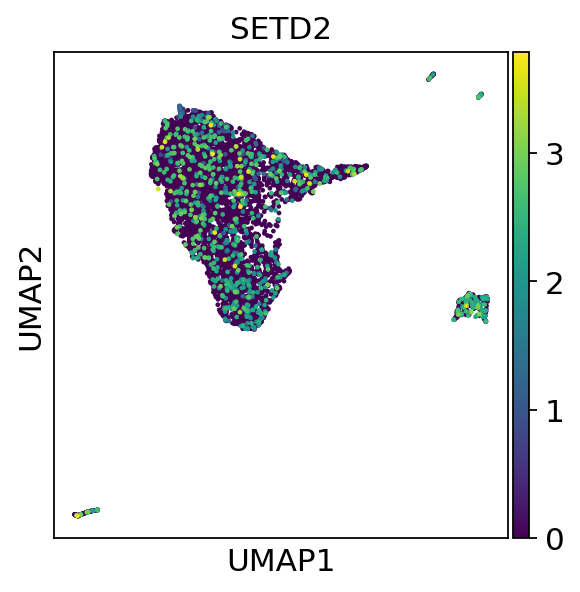

In [66]:
sc.pl.umap(adata, color=['SETD2'], wspace = 0.5, save = '_STP-Nuclei_SETD2_marker_visualization.pdf')

## PROJECT CHROMOTHRIPSIS SIGNATURE ONTO THE EMBEDDING

In [50]:
f="/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/scRNA_analysis/MB_shh_filtered_table_FDR.tsv"
pos_df=pd.read_table(f, sep='\t')
pos_df=pos_df.loc[pos_df['log2FoldChange'] > 0,:]
pos_df=pos_df.loc[pos_df['padj'] <= 0.05,:]
neg_df=pd.read_table(f, sep='\t')
neg_df=neg_df.loc[neg_df['log2FoldChange'] < 0,:]
neg_df=neg_df.loc[neg_df['padj'] <= 0.05,:]

In [51]:
pos_df
neg_df

,ens_fullid,ens_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
409,ENSG00000187097.12_3,ENSG00000187097,1662.242563,-0.359350,0.109875,-3.270523,1.073486e-03,0.036798,ENTPD5
410,ENSG00000250462.8_2,ENSG00000250462,1332.612360,-0.407023,0.128259,-3.173454,1.506366e-03,0.045176,LRRC37BP1
411,ENSG00000076242.14_2,ENSG00000076242,4657.937488,-0.414492,0.112141,-3.696177,2.188700e-04,0.013763,MLH1
412,ENSG00000113812.13_3,ENSG00000113812,6868.479447,-0.436607,0.127945,-3.412451,6.438160e-04,0.026346,ACTR8
413,ENSG00000100890.15_3,ENSG00000100890,808.125224,-0.443807,0.140809,-3.151842,1.622438e-03,0.047158,KIAA0391
...,...,...,...,...,...,...,...,...,...
1042,ENSG00000237869.2,ENSG00000237869,12.804303,-5.767545,1.786001,-3.229307,1.240907e-03,0.040182,RP11-459O16.1
1043,ENSG00000183072.9_2,ENSG00000183072,260.545238,-5.943601,1.123514,-5.290188,1.220000e-07,0.000112,NKX2-5
1044,ENSG00000266736.1_2,ENSG00000266736,102.835417,-6.129589,1.766502,-3.469902,5.206490e-04,0.023260,RP11-260A9.4
1045,ENSG00000253226.1_2,ENSG00000253226,23.377382,-6.273874,1.701660,-3.686913,2.269910e-04,0.014047,HAUS1P3


In [52]:
gene_list_pos=pos_df['gene_name']
intersect_gene_list_pos=adata.var_names.isin(list(gene_list_pos))
gene_list_pos=adata.var_names[intersect_gene_list_pos]

In [53]:
len(gene_list_pos)

40

In [54]:
gene_list_neg=neg_df['gene_name']
intersect_gene_list_neg=adata.var_names.isin(list(gene_list_neg))
gene_list_neg=adata.var_names[intersect_gene_list_neg]

In [55]:
len(gene_list_neg)

189

In [56]:
sc.tl.score_genes(adata, list(gene_list_pos), ctrl_size=len(gene_list_pos), gene_pool=None, n_bins=25, score_name='Upregulated_Chromothripsis_Score', random_state=0, copy=False, use_raw=None)
sc.tl.score_genes(adata, list(gene_list_neg), ctrl_size=len(gene_list_neg), gene_pool=None, n_bins=25, score_name='Downregulated_Chromothripsis_Score', random_state=0, copy=False, use_raw=None)

computing score 'Upregulated_Chromothripsis_Score'
    finished: added
    'Upregulated_Chromothripsis_Score', score of gene set (adata.obs).
    867 total control genes are used. (0:00:00)
computing score 'Downregulated_Chromothripsis_Score'
    finished: added
    'Downregulated_Chromothripsis_Score', score of gene set (adata.obs).
    3160 total control genes are used. (0:00:00)


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


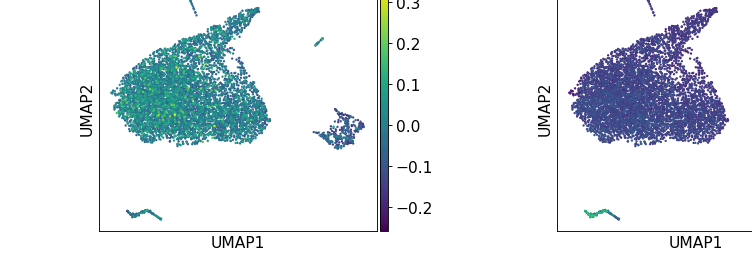

In [57]:
sc.pl.umap(adata, color=['Upregulated_Chromothripsis_Score', 'Downregulated_Chromothripsis_Score'], save = '_STP-Nuclei_chromothripsisScore.pdf', wspace = 0.5)

In [58]:
# assign the column with the cell_type id in the metadata of the annData object
metadata = pd.DataFrame(adata.obs, index=adata.obs_names)
metadata.to_csv('/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/infercnv_MB/scRNA_scDNA/STP-Nuclei_chromothripsisScore_metadata.csv')

In [59]:
metadata

,sample,technology,patient,scrublet__predicted_multiplet,scrublet__multiplet_scores,scrublet__multiplet_zscores,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,louvain,leiden,new_clusters,clone_id,min_pval,Upregulated_Chromothripsis_Score,Downregulated_Chromothripsis_Score
AAACCTGCACATCCAA-1,STP,Nuclei,ST,False,0.136483,-9.669419,521,520,660.0,0.0,0.000000,19.0,2.878788,1,cluster0,malignant SHH I,Clone3,0.001,0.028755,-0.051730
AAACCTGCACTAGTAC-1,STP,Nuclei,ST,False,0.081705,-17.687129,567,566,753.0,2.0,0.265604,9.0,1.195219,1,cluster0,malignant SHH I,Clone6,0.001,-0.034380,-0.035669
AAACCTGCATCATCCC-1,STP,Nuclei,ST,False,0.048703,-31.075762,424,424,548.0,3.0,0.547445,36.0,6.569343,1,cluster2,malignant cycling,Clone2,0.001,-0.053931,-0.047447
AAACCTGGTAGCGATG-1,STP,Nuclei,ST,False,0.159463,-7.937216,3130,3125,6145.0,7.0,0.113914,83.0,1.350692,2,cluster3,neuronal development I,Clone4,0.001,-0.048944,-0.115302
AAACCTGGTAGCTCCG-1,STP,Nuclei,ST,False,0.095554,-14.799332,472,472,596.0,1.0,0.167785,12.0,2.013423,3,cluster1,malignant SHH II,Clone3,0.001,0.068327,-0.028046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTGCGCTTG-1,STP,Nuclei,ST,False,0.123987,-10.878876,1360,1359,1929.0,13.0,0.673924,33.0,1.710731,1,cluster0,malignant SHH I,Clone3,0.001,0.033086,-0.043221
TTTGTCAGTGTTTGTG-1,STP,Nuclei,ST,False,0.159463,-7.937216,963,962,1256.0,2.0,0.159236,29.0,2.308917,1,cluster1,malignant SHH II,Clone3,0.001,-0.053280,-0.087434
TTTGTCAGTTAAAGAC-1,STP,Nuclei,ST,False,0.095554,-14.799332,646,646,833.0,7.0,0.840336,26.0,3.121248,1,cluster0,malignant SHH I,Clone3,0.001,-0.089936,-0.081297
TTTGTCATCATCGGAT-1,STP,Nuclei,ST,False,0.081705,-17.687129,1216,1216,1729.0,9.0,0.520532,37.0,2.139965,0,cluster2,malignant cycling,Clone2,0.001,-0.120338,-0.072015


In [60]:
data_crosstab = pd.crosstab(metadata['new_clusters'], metadata['clone_id'], margins = False)
print(data_crosstab)

clone_id                 Clone2  Clone3  Clone4  Clone5  Clone6  nan   
new_clusters                                                           
malignant SHH I             358     724     406     100      10       0
malignant SHH II            368     597     449     159      21       0
malignant cycling           221     350     870      22      11       0
neuronal development I      254     395     330      47       8       0
neuronal development II     147      95     248      15       9       0
meninge cells                 0       0       0       0       0     282
macrophages                   0       0       0       0       0      88
purkinje cells                0       0       0       0       0      26
endothelial cells             0       0       0       0       0      25


In [61]:
data_crosstab.to_csv('/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/infercnv_MB/scRNA_scDNA/STP-Nuclei_contingencyTable_celltypes_clones.csv')